Initialization

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print("Finished importing utils!")

Finished importing utils!


In [2]:
import yfinance as yf
import pandas as pd


tickers = ['AAPL','GOOG','MSFT','AMZN','INTC','AMD','NVDA','F','TSLA', 'JPM','MS','VOO']

### Save tickers data in seperate files
for ticker in tickers:
    ticker_data = yf.Ticker(ticker)
    data = yf.download(ticker, start='2018-01-01', end='2023-12-31')
    df = pd.DataFrame(data)
    df['ticker'] = ticker
    df.to_csv(f'{ticker}_data.csv', index=True)

ModuleNotFoundError: No module named 'yfinance'

In [ ]:
import yfinance as yf
import pandas as pd
# Define datasets paths
# works in my computer,but not with repo.
datasets = [
    'dwu359/ml-portfolio-optimization/dataset/10yInterestrate_dataset.csv',
    'dwu359/ml-portfolio-optimization/dataset/GDP_dataset.csv',
    'dwu359/ml-portfolio-optimization/dataset/Median Consumer Price Index.csv',
    'dwu359/ml-portfolio-optimization/dataset/personal_saving_rate_dataset.csv',
    'dwu359/ml-portfolio-optimization/dataset/unemployed_dataset.csv'
]

# Create an empty DataFrame to store merged data
merged_df = pd.DataFrame({'DATE': pd.date_range(start='2018-01-01', end='2023-12-31', freq='MS')})
merged_df.set_index('DATE', inplace=True)

# Merge datasets based on 'DATE' column
for path in datasets:
    temp_df = pd.read_csv(path)
    temp_df['DATE'] = pd.to_datetime(temp_df['DATE'])
    temp_df.set_index('DATE', inplace=True)
    
    # Merge on 'DATE' column
    merged_df = pd.merge(merged_df, temp_df, left_index=True, right_index=True, how='left')

# Fill missing values with values from the previous month
merged_df.fillna(method='ffill', inplace=True)

# Save the merged DataFrame to a CSV file
merged_df.to_csv('./dataset/econ_data.csv', index=True)

FileNotFoundError: [Errno 2] No such file or directory: 'dwu359/ml-portfolio-optimization/dataset/10yInterestrate_dataset.csv'

## ARIMA 

In [3]:
# Import libraries for ARIMA
# !pip install pmdarima

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

from src.myarima import MyARIMA

In [4]:
# Load the dataset for the first ticker
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
stock_data = pd.read_csv('dataset\AAPL_data.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,ticker
Date,,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.670986,102223600,AAPL
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.663898,118071600,AAPL
2018-01-04,43.134998,43.367500,43.020000,43.257500,40.852768,89738400,AAPL
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.317894,94640000,AAPL
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.164425,82271200,AAPL


In [5]:
# Check the shape of the dataset
print(stock_data.shape)

# Check the start and end date of the dataset
print(stock_data.index.min())
print(stock_data.index.max())

# Duration of stock data
duration = stock_data.index.max() - stock_data.index.min()
print(duration)

(1509, 7)
2018-01-02 00:00:00
2023-12-29 00:00:00
2187 days 00:00:00


In [6]:
# Data Cleaning and Sanity Check

# Check for missing values
print(stock_data.isnull().sum(), '\n')

# Check for duplicate values
print(stock_data.duplicated().sum())

# Describe the dataset
print(stock_data.describe())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
ticker       0
dtype: int64 

0
              Open         High          Low        Close    Adj Close  \
count  1509.000000  1509.000000  1509.000000  1509.000000  1509.000000   
mean    110.326080   111.583562   109.157902   110.428236   108.703985   
std      51.003328    51.520038    50.513390    51.043671    51.349589   
min      35.994999    36.430000    35.500000    35.547501    34.075390   
25%      54.105000    54.794998    53.290001    53.872501    51.655396   
50%     123.660004   124.980003   122.139999   123.540001   121.447418   
75%     152.570007   154.559998   150.800003   152.740005   151.446182   
max     198.020004   199.619995   197.000000   198.110001   197.857529   

             Volume  
count  1.509000e+03  
mean   1.073273e+08  
std    5.513331e+07  
min    2.404830e+07  
25%    7.078370e+07  
50%    9.296430e+07  
75%    1.280440e+08  
max    4.265100e+08  


# Data Visualization

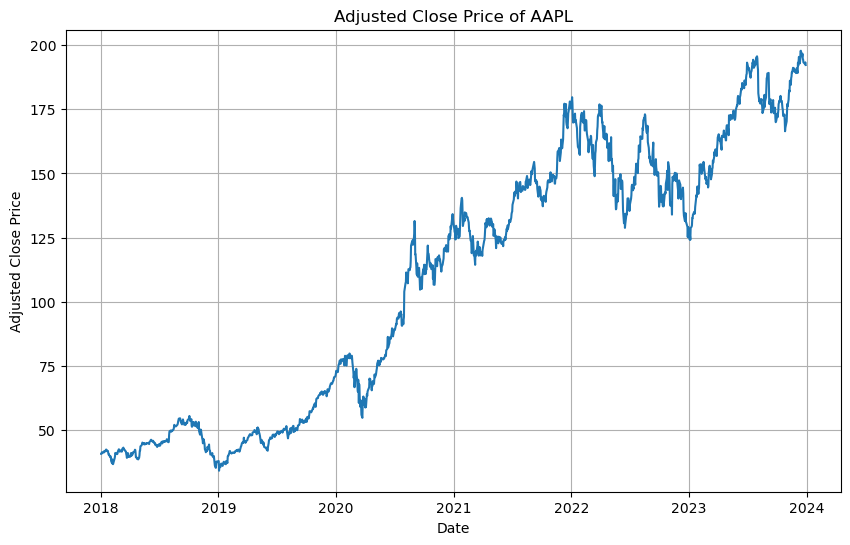

In [7]:
# Plot the adjusted close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.title('Adjusted Close Price of AAPL')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.plot(stock_data['Adj Close'])
plt.show()

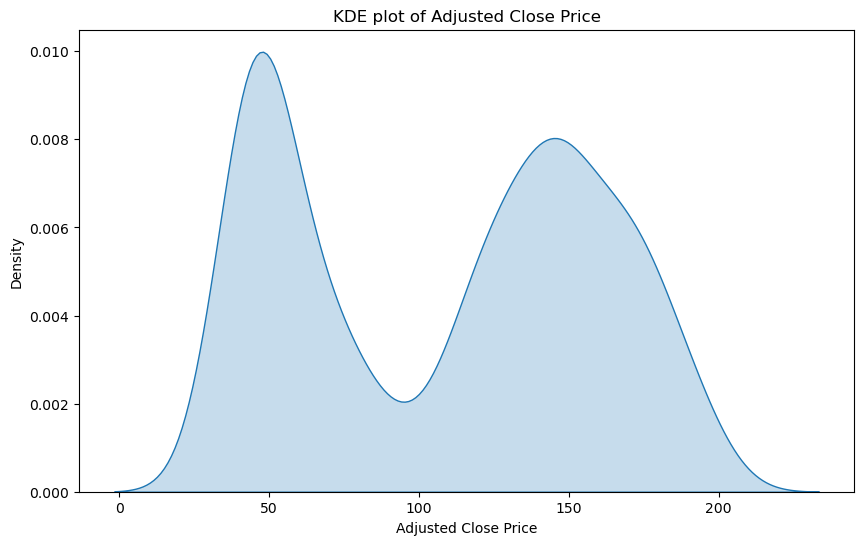

In [8]:
# KDE plot of the adjusted close price
plt.figure(figsize=(10,6))
sns.kdeplot(stock_data['Adj Close'], shade=True)
plt.title('KDE plot of Adjusted Close Price')
plt.xlabel('Adjusted Close Price')
plt.ylabel('Density')
plt.show()

# Check for stationarity

In [9]:
# Check for stationarity using the Augmented Dickey-Fuller test
adj_closed = stock_data['Adj Close']
arima = MyARIMA(adj_closed)

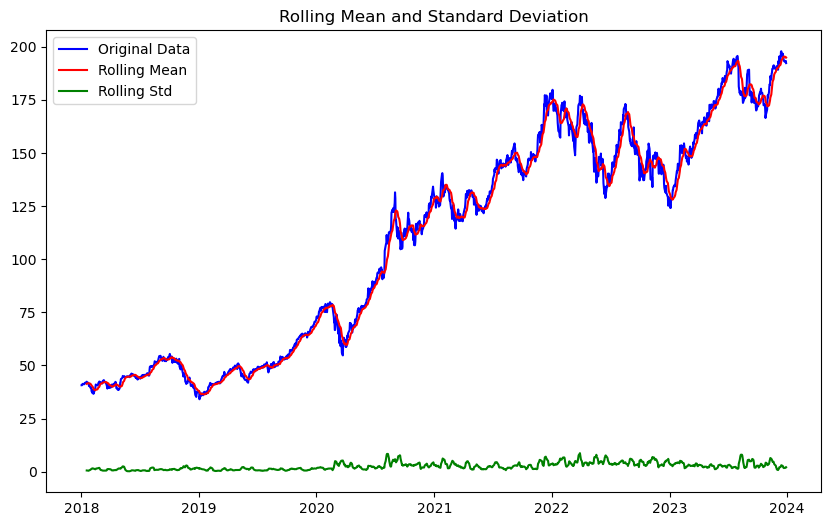

ADF Statistic: -0.5118330349413805
p-value: 0.8896866005103121
Critical Values:
1%: -3.434696697851678
5%: -2.8634597924260303
10%: -2.567792072971565


In [10]:
arima.check_stationarity()

The plot depicts increasing mean and standard deviation. Additionally p-value > 0.05. Hence, the timeseries is not stationary.

Additionally, the test statistics exceeds the critical values. As a result, the data is nonlinear.

<Figure size 1000x600 with 0 Axes>

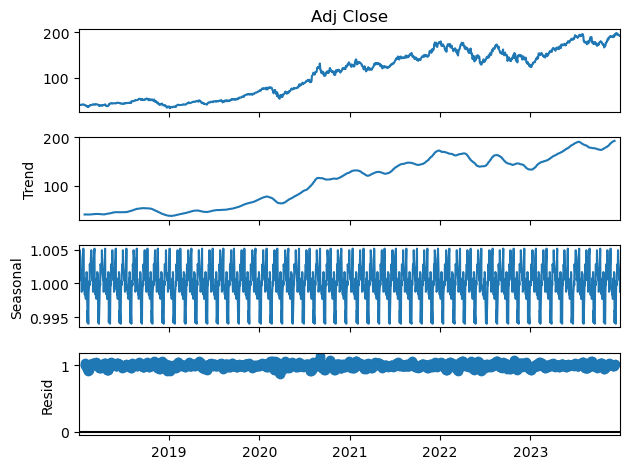

In [11]:
# Decompose the time series
result = seasonal_decompose(adj_closed, model='multiplicative', period=30)
plt.figure(figsize=(10,6))
result.plot()
plt.show()

### Make the time-series stationary

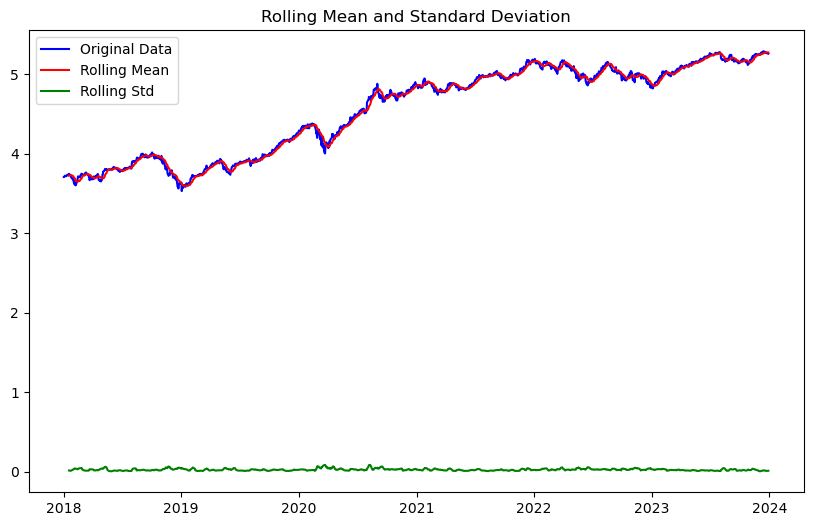

In [12]:
# Taking the log of the time series
log_data = arima.log_data()

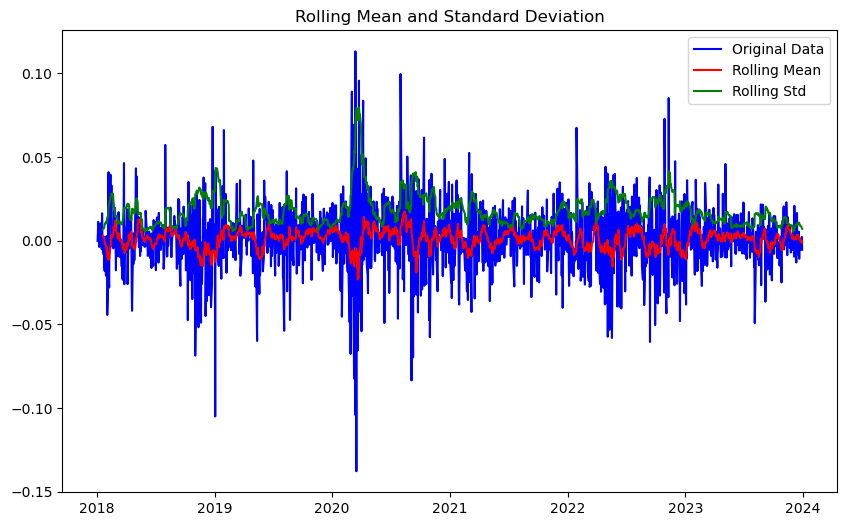

In [13]:
# Differencing the log of the time series
diff_data = arima.difference_data(log_data)

### ACF and PACF plots 

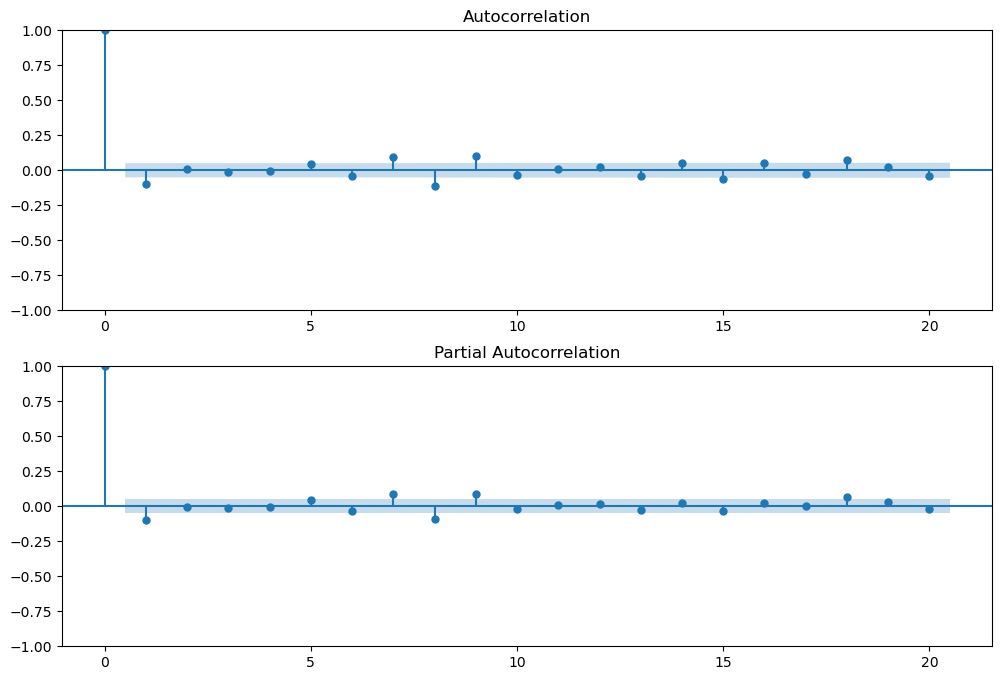

In [14]:
arima.acf_pacf_plots(diff_data)

### Grid search for parameters